In [23]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon

import matplotlib.pyplot as plt
import numpy as np

from bot_2d_rep import *
from bot_2d_problem import *

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Set up a simple robot

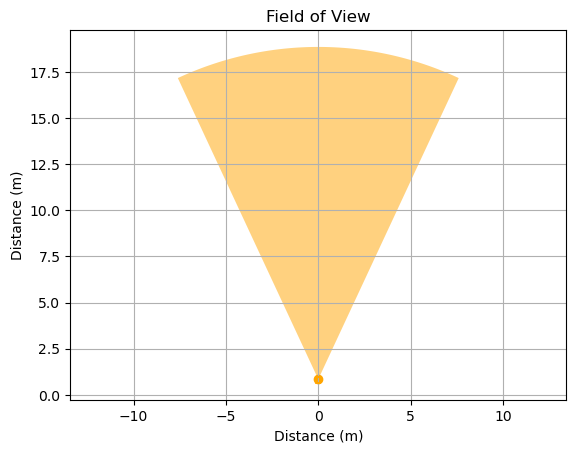

In [24]:
sensor_bounds = Polygon([(.1,.1), (-.1,.1),(-.1,-.2),(.1,-.2)])

sensors = [FOV2D_Simple(hfov=50, distance=18, focal_point=(0,.85), color='orange', cost=99.00, bounds_polygon=copy.deepcopy(sensor_bounds)),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(-.85,.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(60),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(-.85,-.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(120),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(.85,.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(-60),
           FOV2D_Simple(hfov=90, distance=10, focal_point=(.85,-.35), cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)).rotate(-120)]
sensors[0].plot_fov(whole_plot=True)


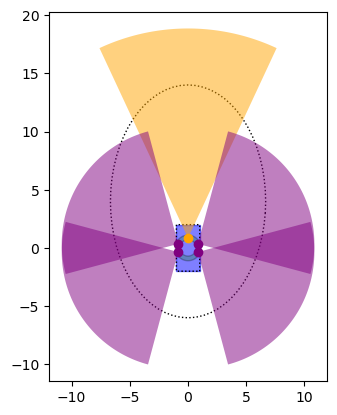

Bot Sensor Package is invalid because sensor is outside of physical constraints.
Perception Coverage: 89.88657311952292%
Perception Cost: $419.0


In [25]:
bot_diam = 1
bot_bounds = Polygon([(-1, -2), (-1, 2), (1, 2), (1, -2)])
sens_constraint = Polygon(shapely.geometry.Point(0, 0).buffer(bot_diam/1-.1).exterior.buffer(0.2))
sense_requirement =  Polygon(shapely.geometry.Point(0, 0).buffer(10).exterior.coords)
sense_requirement = shapely.affinity.scale(sense_requirement, xfact=2/3, yfact=1, origin=(0, 0))
sense_requirement = shapely.affinity.translate(sense_requirement, xoff=0, yoff=4)
bot = SimpleBot2d(bot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint)
bot.add_sensors_2d(sensors)

bot.plot_bot(show_constraint=True)

bot.is_valid_pkg()
print(f"Perception Coverage: {bot.get_sensor_coverage()*100}%")
print(f"Perception Cost: ${bot.get_pkg_cost()}")

## Rotate a sensor to test

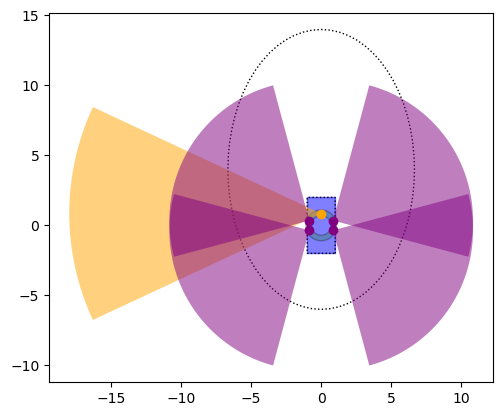

Bot Sensor Package is Valid!


In [26]:
# Rotate the first sensor by 45 degrees
bot.sensors[0].rotate(90)

# Plot the bot with the updated sensor
bot.plot_bot(show_constraint=True)

bot.is_valid_pkg()
bot.get_sensor_coverage()

bot.sensors[0].rotate(-90)

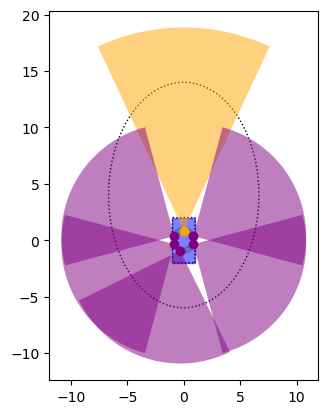

Bot Sensor Package is invalid because sensor is outside of physical constraints.


0.9555591722347484

In [27]:
# Add a sensor in a random valid pose
bot.add_sensor_valid_pose(FOV2D_Simple(hfov=90, distance=10, cost=80.00, bounds_polygon=copy.deepcopy(sensor_bounds)))

bot.plot_bot(show_constraint=True)

bot.is_valid_pkg()
bot.get_sensor_coverage()

# Set up & run the simple optimization problem

In [28]:
from pymoo.problems.functional import FunctionalProblem

sensor_options = [FOV2D_Simple(hfov=90, distance=10, cost=80.00, color="purple", bounds_polygon=copy.deepcopy(sensor_bounds)),
                  FOV2D_Simple(hfov=75, distance=9, cost=30.00, color="pink", bounds_polygon=copy.deepcopy(sensor_bounds))]

problem = SensorPkgOptimization(bot, sensor_options, 8)

print(problem.vars)

# F, G = problem.evaluate(np.array([problem.convert_bot_to_1D(bot)]))

# print(f"F: {F}")
# print(f"G: {G}")
# print(f"H: {H}")

{'s0_type': <pymoo.core.variable.Integer object at 0x32239d450>, 's0_x': <pymoo.core.variable.Real object at 0x3227cff50>, 's0_y': <pymoo.core.variable.Real object at 0x3224ef050>, 's0_rotation': <pymoo.core.variable.Real object at 0x32239f150>, 's1_type': <pymoo.core.variable.Integer object at 0x32239d690>, 's1_x': <pymoo.core.variable.Real object at 0x32239c250>, 's1_y': <pymoo.core.variable.Real object at 0x3225dcf10>, 's1_rotation': <pymoo.core.variable.Real object at 0x3225de850>, 's2_type': <pymoo.core.variable.Integer object at 0x3224a0f50>, 's2_x': <pymoo.core.variable.Real object at 0x3224a3810>, 's2_y': <pymoo.core.variable.Real object at 0x3224a3110>, 's2_rotation': <pymoo.core.variable.Real object at 0x3224a3cd0>, 's3_type': <pymoo.core.variable.Integer object at 0x3224a0cd0>, 's3_x': <pymoo.core.variable.Real object at 0x3224a2a90>, 's3_y': <pymoo.core.variable.Real object at 0x3224a2b50>, 's3_rotation': <pymoo.core.variable.Real object at 0x3224a2ad0>, 's4_type': <pymoo.c

In [29]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling


algorithm = NSGA2(
    pop_size=50,
    n_offsprings=10,
    sampling=CustomSensorPkgRandomSampling(),
    # crossover=SBX(prob=0.9, eta=15),
    # mutation=PM(eta=20),
    eliminate_duplicates=False
)

res = minimize(problem,
               algorithm,
               ('n_gen', 200),
               seed=1,
               verbose=False)

plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res.F, facecolor="none", edgecolor="red")
plot.show()

X: [array([ 1.00000000e+00,  7.56940185e-02,  9.10517000e-01,  3.55247757e+02,
        1.00000000e+00,  5.45466803e-02, -9.15828772e-01,  1.83408505e+02,
        2.00000000e+00, -9.89885550e-01,  7.89547975e-02,  8.54396548e+01,
        1.00000000e+00,  4.97086678e-01,  8.43088717e-01,  3.29476319e+02,
        1.00000000e+00, -8.75110790e-01, -4.64718969e-01,  1.17970097e+02,
        1.00000000e+00,  7.99616919e-01,  5.43548546e-01,  3.04206345e+02]), array([ 1.00000000e+00,  7.56940185e-02,  9.10517000e-01,  3.55247757e+02,
        1.00000000e+00,  5.45466803e-02, -9.15828772e-01,  1.83408505e+02,
        2.00000000e+00, -9.89885550e-01,  7.89547975e-02,  8.54396548e+01,
        1.00000000e+00,  4.97086678e-01,  8.43088717e-01,  3.29476319e+02,
        1.00000000e+00, -8.75110790e-01, -4.64718969e-01,  1.17970097e+02,
        1.00000000e+00,  7.99616919e-01,  5.43548546e-01,  3.04206345e+02,
        2.00000000e+00,  9.15975497e-01, -8.32462361e-02,  2.64807076e+02,
        1.00000000e

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (50,) + inhomogeneous part.